In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import re
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

I0529 19:25:18.847158 27032 file_utils.py:41] PyTorch version 1.1.0 available.


In [2]:
CLEANED_NAMES_FILE = "../Data/category_cleaned_names.csv"

In [3]:
model = SentenceTransformer('bert-large-nli-mean-tokens')

I0529 19:25:26.988024 27032 SentenceTransformer.py:29] Load pretrained SentenceTransformer: bert-large-nli-mean-tokens
I0529 19:25:26.992012 27032 SentenceTransformer.py:32] Did not find a '/' or '\' in the name. Assume to download model from server.
I0529 19:25:26.996999 27032 SentenceTransformer.py:67] Load SentenceTransformer from folder: C:\Users\Jai/.cache\torch\sentence_transformers\public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-large-nli-mean-tokens.zip
I0529 19:25:27.055846 27032 configuration_utils.py:281] loading configuration file C:\Users\Jai/.cache\torch\sentence_transformers\public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-large-nli-mean-tokens.zip\0_BERT\config.json
I0529 19:25:27.057840 27032 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": null,
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
 

In [4]:
she_vec, he_vec = model.encode(['she', 'he'])
she_vec = she_vec.reshape(1, -1)
he_vec = he_vec.reshape(1, -1)
he_she_axis = normalize(np.subtract(she_vec, he_vec))

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


In [7]:
np.vdot(he_she_axis, normalize(she_vec))

0.3718275

In [5]:
df_brands = pd.read_csv('../Data/alignment_scores.csv')
df_brands = df_brands[df_brands.columns[1:]]
brands = df_brands['brand']

In [6]:
def get_simple_alignment(brands, gender_subspace):
    vectors=normalize(model.encode(brands))
    gen_comp = np.dot(vectors, gender_subspace)
#     if gen_comp < 0:
#         return 'M'
#     else:
#         return 'F'
    return gen_comp

In [7]:
alignment = get_simple_alignment(brands, he_she_axis[0])

Batches: 100%|██████████| 184/184 [01:44<00:00,  1.29it/s]


In [8]:
df_brands['bert_alignment'] = alignment


In [9]:
df_brands.reset_index().sort_values(by='bert_alignment')
old_alignment = df_brands['alignment']
bert_alignment = df_brands['bert_alignment']
pearsonr(old_alignment, bert_alignment)

(0.3734616111495973, 6.739373238477937e-50)

In [10]:
def preprocess(category):
    category = category[5:]
    category = re.sub(",|'s|& |/", ' ', category)
    category = re.sub("  ", " ", category )
    return category.lower()

In [15]:
df_brands_no_dup = pd.read_csv('../Data/brand_names_coded_no_duplicates.csv')
def get_brand_categories(brands, concise=False):
    if concise:
        cleaned_name_map = pd.read_csv(CLEANED_NAMES_FILE).set_index('Original').to_dict()['Concise']
    else:
        cleaned_name_map = pd.read_csv(CLEANED_NAMES_FILE).set_index('Original').to_dict()['Corrected']
    valid_df = df_brands_no_dup[df_brands_no_dup['BRAND'].isin(brands)]
    brand_category_mapping = valid_df.set_index('BRAND').to_dict()['CATEGORY']
    brand_category_cleaned = {brand: preprocess(cleaned_name_map[category]) for brand, category in brand_category_mapping.items()}
#     brand_category_mapping = {brand: preprocess(category) for brand, category in brand_category_cleaned.items()}
    return brand_category_cleaned, set(brand_category_cleaned.values())

In [16]:
brand_category_mapping, categories = get_brand_categories(brands)
category_alignment = get_simple_alignment(list(categories), he_she_axis[0])

Batches: 100%|██████████| 9/9 [00:06<00:00,  1.12it/s]


In [19]:
category_alignment.shape
print(len(alignment))
print("LENGTH OF ALIGNMENT", len(bert_alignment[bert_alignment>0]))
print("LENGTH OF RESIDUAL ALIGNMENT", len(category_alignment[category_alignment>0]))
print(len(category_alignment))
print(len(alignment[alignment>0])/len(alignment))
print(len(category_alignment[category_alignment>0])/len(category_alignment))


1471
LENGTH OF ALIGNMENT 244
LENGTH OF RESIDUAL ALIGNMENT 45
72
0.16587355540448676
0.625


In [21]:
cat_al = pd.DataFrame({'category': list(categories), 'alignment': category_alignment})
cat_al['gender'] = cat_al['alignment'].apply(lambda x: 'F' if x >=0 else 'M')
cat_al.sort_values(by='category').to_csv('../Data/new_bert_category_alignment.csv')

In [25]:
brand_category_mapping

{'aacsb': 'religious charitable humanitarian',
 'aarp': 'investment products services',
 'abbotts': 'ice cream frozen novelties sherbet',
 'abc': 'tv networks stations production companies',
 'aberdeen': 'investment products services',
 'abound': 'cat dog food',
 'abuelita': 'cocoa milk additives',
 'abuelos': 'casual dining restaurants',
 'acdelco': 'household batteries',
 'acer': 'desktop computers',
 'acme': 'fishing tackle equipment',
 'acteon': 'bedding linens',
 'adams': 'peanut butter sandwich spreads',
 'addiction': 'cat dog food',
 'adidas': 'sportswear athleticwear',
 'admonsters': 'advertising marketing printing services',
 'admore': 'advertising marketing printing services',
 'adt': 'security fire safety systems',
 'advantech': 'desktop computers',
 'advantedge': 'nutritional supplements',
 'advil': 'pain remedies',
 'advocare': 'nutritional supplements',
 'aecom': 'loan credit products services',
 'aflac': 'tv networks stations production companies',
 'afp': 'sporting good

In [26]:
def get_residual_alignment(brands, categories, brand_category_mapping, gender_subspace):
    brand_vecs = model.encode(brands)
    category_vecs = model.encode(categories)
    for i in range(len(brands)):
        brand_vecs[i] -= category_vecs[categories.index(brand_category_mapping[brands[i]])]
        
    vectors=normalize(brand_vecs)
    gen_comp = np.dot(vectors, gender_subspace)
#     if gen_comp < 0:
#         return 'M'
#     else:
#         return 'F'
    return gen_comp

In [27]:
resid = get_residual_alignment(brands, list(categories), brand_category_mapping, he_she_axis[0])

Batches: 100%|██████████| 9/9 [00:06<00:00,  1.12it/s]


In [34]:
df_brands['residual_bert_alignment'] = resid
df_brands.to_csv('../Data/bert_analysis.csv')

In [29]:
print(len(alignment))
print("LENGTH OF ALIGNMENT", len(bert_alignment[bert_alignment>0]))
print("LENGTH OF RESIDUAL ALIGNMENT", len(resid[resid>0]))

print(len(resid))
print(len(alignment[alignment>0])/len(alignment))
print(len(resid[resid>0])/len(resid))

1471
LENGTH OF ALIGNMENT 244
LENGTH OF RESIDUAL ALIGNMENT 297
1471
0.16587355540448676
0.20190346702923181


In [112]:
df_brands['category'] = df_brands['brand'].apply(lambda x: brand_category_mapping[x])
count_df = df_brands.groupby(by='category').count()
frequent_categories = count_df[count_df['brand'] > 20].index.tolist()
shortened_df = df_brands[df_brands['category'].isin(frequent_categories)]
shortened_df['gender_old'] = shortened_df['alignment'].apply(lambda x: 1 if x >=0 else 0)
shortened_df['gender_bert'] = shortened_df['bert_alignment'].apply(lambda x: 1 if x >=0 else 0)
category_counts = shortened_df.groupby(by='category').sum()
category_counts['female_old'] = category_counts['gender_old'] / count_df['brand']
category_counts['female_bert'] = category_counts['gender_bert'] / count_df['brand']
category_counts

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,alignment,bert_alignment,gender_old,gender_bert,female_old,female_bert
category,,,,,,
advertising marketing printing services,1.334027,-3.505877,38,8,0.703704,0.148148
bedding linens,3.101857,-1.801358,30,8,0.882353,0.235294
beer ale,2.082105,-2.806780,41,10,0.672131,0.163934
casual dining restaurants,2.641990,-3.327136,37,8,0.770833,0.166667
cookies crackers,2.798017,-1.049007,26,9,0.838710,0.290323
credit cards,1.372837,-1.990738,25,2,0.892857,0.071429
dinnerware glassware pottery,2.218616,-1.062778,25,8,0.806452,0.258065
fishing tackle equipment,1.078341,-2.557333,28,5,0.736842,0.131579
handbags,3.578966,-0.479390,23,8,0.851852,0.296296


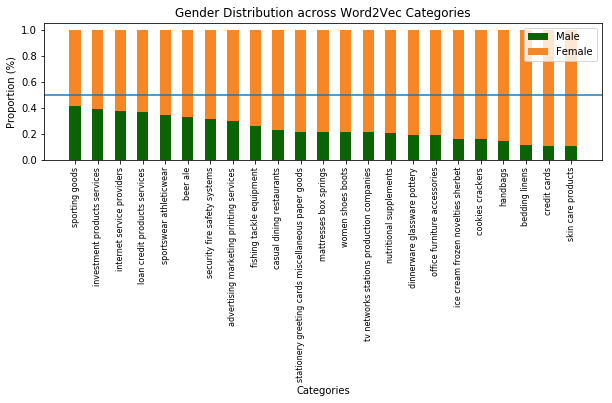

In [227]:
old_order = category_counts.sort_values(by='female_old')  
cat_ind = old_order.index
indices = [i for i in range(len(cat_ind))]
sub_m = (1 - old_order['female_old']).tolist()
sub_f = old_order['female_old'].tolist()
sub_c = old_order.index
barWidth = 0.5
plt.bar(indices, sub_m, color='#0b6304', width=barWidth, label="Male")
plt.bar(indices, sub_f, bottom=sub_m, color='#f78725', width=barWidth, label="Female")
plt.xticks(indices, sub_c, rotation='vertical', fontsize=8)
plt.xlabel("Categories")
plt.ylabel("Proportion (%)")
plt.title("Gender Distribution across Word2Vec Categories")
plt.legend()
plt.axhline(y=0.5)
plt.rcParams["figure.figsize"] = [10, 5]
plt.gcf().subplots_adjust(bottom=0.50)
plt.savefig('category_distribution_word2vec.png', dpi=150)
# plt.clf()


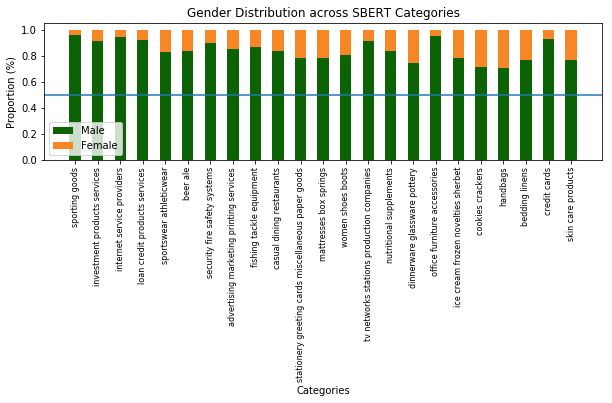

In [228]:

plt.clf() 
indices = [i for i in range(len(cat_ind))]
sub_m = (1 - old_order['female_bert']).tolist()
sub_f = old_order['female_bert'].tolist()
sub_c = old_order.index
barWidth = 0.5
plt.bar(indices, sub_m, color='#0b6304', width=barWidth, label="Male")
plt.bar(indices, sub_f, bottom=sub_m, color='#f78725', width=barWidth, label="Female")
plt.xticks(indices, sub_c, rotation='vertical', fontsize=8)
plt.xlabel("Categories")
plt.ylabel("Proportion (%)")
plt.title("Gender Distribution across SBERT Categories")
plt.legend()
plt.rcParams["figure.figsize"] = [10, 5]
plt.gcf().subplots_adjust(bottom=0.50)
plt.axhline(y=0.5)
plt.savefig('category_distribution_bert.png', dpi=150)
# plt.tight_layout()

In [144]:
df_human = pd.read_csv('../Data/human_names_coded.csv')
df_human = df_human.drop(["dataID"], axis=1)
df_human = df_human.drop(["Name"], axis=1)
x = df_human.drop(['Gender', 'is_unique'], axis=1).as_matrix()[:, 1:]
y = df_human[['Gender']].as_matrix().ravel()
model_LR = LogisticRegression()
model_LR.fit(x, y)
df_brands = pd.read_csv('../Data/brand_names_coded_no_duplicates.csv')
print(df_brands.shape)
# df_brands = df_brands.drop_duplicates(subset='BRAND')
maps = {}
for i in range(len(df_brands.index)):
    feature_vec = df_brands.iloc[i][4:].as_matrix().ravel().reshape((1, -1))
#     print(feature)
    x = model_LR.predict_proba(feature_vec)
#     print(df_brands.iloc[i][2], x)
    maps[df_brands.iloc[i][2]] = 0 if x[0][0] > x[0][1] else 1

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(2308, 20)


c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
c:\users\jai\desktop\bgp-wordembedding\bgp_venv\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.pat

In [178]:
keys = np.array([[key, int(value)] for key, value in maps.items() if key in brands.tolist()])
# vals = list(maps.values())
ss_df = pd.DataFrame({'brand': keys[:,0], 'gender': keys[:, 1]})
ss_df['category'] = ss_df['brand'].apply(lambda x: brand_category_mapping[x])
ss_df['gender'] = ss_df['gender'].astype(int)
ss_count_df = ss_df.groupby(by='category').count()
ss_shortened_df = ss_df[ss_df['category'].isin(frequent_categories)]
ss_category_counts = ss_shortened_df.groupby(by='category').sum()
ss_category_counts['female_ss'] = ss_category_counts['gender'] / ss_count_df['brand']
ss_category_counts = ss_category_counts.reindex(old_order.index)

,gender,female_ss
category,,
sporting goods,8,0.333333
investment products services,25,0.316456
internet service providers,12,0.226415
loan credit products services,15,0.394737
sportswear athleticwear,43,0.401869
beer ale,16,0.262295
security fire safety systems,28,0.354430
advertising marketing printing services,24,0.444444
fishing tackle equipment,15,0.394737


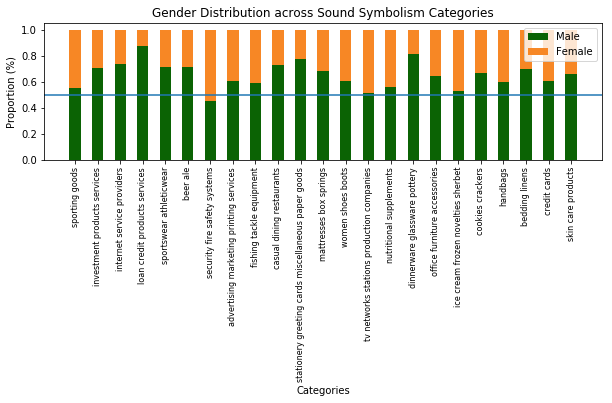

In [229]:
plt.clf() 
indices = [i for i in range(len(cat_ind))]
sub_m = (1 - ss_category_counts['female_ss']).tolist()
sub_f = ss_category_counts['female_ss'].tolist()
sub_c = old_order.index
barWidth = 0.5
plt.bar(indices, sub_m, color='#0b6304', width=barWidth, label="Male")
plt.bar(indices, sub_f, bottom=sub_m, color='#f78725', width=barWidth, label="Female")
plt.xticks(indices, sub_c, rotation='vertical', fontsize=8)
plt.xlabel("Categories")
plt.ylabel("Proportion (%)")
plt.title("Gender Distribution across Sound Symbolism Categories")
plt.legend()
plt.rcParams["figure.figsize"] = [10, 5]
plt.gcf().subplots_adjust(bottom=0.50)
plt.axhline(y=0.5)
plt.savefig('category_distribution_sound_symbolism.png', dpi=150)

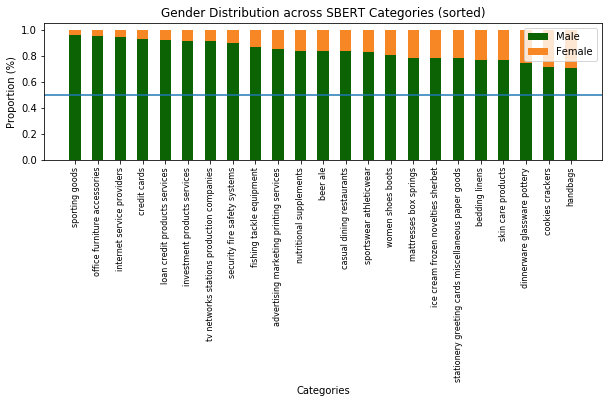

In [230]:
# DO SOUND SYMBOLISM FOR THE SAME BRANDS AS ABOVE

plt.clf()
new_order = category_counts.sort_values(by='female_bert')  
indices = [i for i in range(len(cat_ind))]
sub_m = (1 - new_order['female_bert']).tolist()
sub_f = new_order['female_bert'].tolist()
sub_c = new_order.index
barWidth = 0.5
plt.bar(indices, sub_m, color='#0b6304', width=barWidth, label="Male")
plt.bar(indices, sub_f, bottom=sub_m, color='#f78725', width=barWidth, label="Female")
plt.xticks(indices, sub_c, rotation='vertical', fontsize=8)
plt.xlabel("Categories")
plt.ylabel("Proportion (%)")
plt.title("Gender Distribution across SBERT Categories (sorted)")
plt.legend()
plt.rcParams["figure.figsize"] = [10, 5]
plt.gcf().subplots_adjust(bottom=0.50)
plt.axhline(y=0.5)
plt.savefig('category_distribution_bert_sorted.png', dpi=150)
# plt.tight_layout()

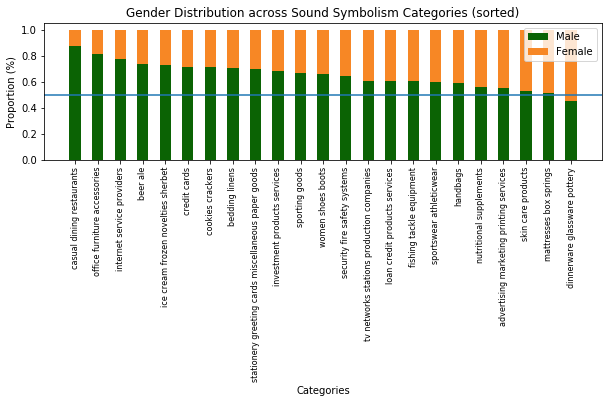

In [231]:
plt.clf() 
indices = [i for i in range(len(cat_ind))]
ss_category_counts_new = ss_category_counts.sort_values(by='female_ss')
sub_m = (1 - ss_category_counts_new['female_ss']).tolist()
sub_f = ss_category_counts_new['female_ss'].tolist()
sub_c = ss_category_counts_new.index
barWidth = 0.5
plt.bar(indices, sub_m, color='#0b6304', width=barWidth, label="Male")
plt.bar(indices, sub_f, bottom=sub_m, color='#f78725', width=barWidth, label="Female")
plt.xticks(indices, sub_c, rotation='vertical', fontsize=8)
plt.xlabel("Categories")
plt.ylabel("Proportion (%)")
plt.title("Gender Distribution across Sound Symbolism Categories (sorted)")
plt.legend()
plt.rcParams["figure.figsize"] = [10, 5]
plt.gcf().subplots_adjust(bottom=0.50)
plt.axhline(y=0.5)
plt.savefig('category_distribution_sound_symbolism_sorted.png', dpi=150)

In [240]:
df_brands[df_brands['brand'].isin(['hims', 'grandmas'])]

,brand,alignment,bert_alignment
1276,hims,0.129329,-0.37312
1437,grandmas,0.232355,0.41752
